In [49]:
import numpy as np
import torch 
import tudatpy 
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

import math
import time
import matplotlib.pyplot as plt
g = 9.81

In [2]:
def pendulum_eom(time, state, m, l): 
    '''
    Return the RHS of the ODE describing a pendulum in terms of an angle
    '''
    angle, angle_dot = state[0], state[1]
    
    d_angle = angle_dot
    d_angle_dot = -g * np.sin(angle)/l
    
    return np.array([d_angle, d_angle_dot]) 

In [61]:
def pendulum_hamiltonian(states, m, l):  
    '''
    Return the hamiltonian of a 2D-pendulum in terms of canonical coodinates
    '''
    
    q, p = states[..., 0], states[..., 1]
    T = (p**2)/(2*m*l**2)
    V = m*g*l*(1 - np.cos(q)) 
    
    return T+V

def pendulum_hamilton(time, state, m, l): 
    '''
    Return the hamilton equations of a 2D-pendulum in terms of canonical coodinates
    '''
    
    q, p = state[0], state[1] 
    dqdt = p/(m*l**2)
    dpdt = -m * g * l * np.sin(q)

    return np.array([dqdt, dpdt]) 

def pendulum_dV(q, m, l):
    return -m * g * l * np.sin(q)

def pendulum_dT(p, m, l): 
    return p/(m*l**2)

def gen_to_can(gen, m, l): 
    '''
    Convert the generlised coordinates to the canonical coordinates for 
    a 2D-pendulum
    '''
    
    can = np.zeros(gen.shape)
    can[:,0:2] = gen[:,0:2]
    can[:,2]  = gen[:,2] * (m*l**2) 
    
    return can

def can_to_gen(can, m, l): 
    '''
    Convert the canonical coordinates to the generalized coordinates for 
    a 2D-pendulum
    '''
    
    gen = np.zeros(can.shape)
    gen[:,0:2] = can[:,0:2]
    gen[:,2]  = can[:,2] / (m*l**2) 
    
    return gen

In [65]:
def integrate(fun, y0, t0, tf, method = "rk45", step_size = None, rtol = 1e-8, atol = 1e-8, args=None): 
    '''
    Integrate an arbitrary initial value problem with several methods
    '''
    
    start = time.time()
    
    if method == "euler": 
        assert  step_size != None,"Time step is not set"
        states, evals = euler(fun, y0, t0, tf, step_size, args)
        
    if method == "rk4": 
        assert  step_size != None,"Time step is not set"
        states, evals = rk4(fun, y0, t0, tf, step_size, args)
        
    if method == "leapfrog": 
        assert len(fun) == 2 and type(fun) == list, "fun should be a list with two functions; [dqdt(p, *args), dpdt(q, *args)"
        assert  step_size != None,"Time step is not set"
        states, evals = leapfrog(fun[0], fun[1], y0, t0, tf, step_size, args)
        
    if method == "rk45": 
        states, evals = solve_ivp_wrapper(fun, y0, t0, tf, rtol = rtol, method = "RK45", atol = atol, args=args)
        
    if method == "dop853": 
        states, evals = solve_ivp_wrapper(fun, y0, t0, tf, rtol = rtol, method = "DOP853", atol = atol, args=args)
    
    end = time.time()
    time_elapsed = end - start
    
    return states, evals, time_elapsed
        
def euler(fun, y0, t0, tf, step_size, args): 
    '''
    Solve an IVP with the euler method
    '''
    
    # Prepare integration
    steps = math.ceil((tf - t0)/step_size)
    states = np.zeros((steps, len(y0)+1)) 
    times = np.linspace(t0, tf, steps) 
    states[0] = np.append([t0], y0)
    evals = len(times) - 1 
    
    # Integrate 
    for i, time in enumerate(times[1:]):
        
        states[i+1, 0] = time
        states[i+1,1:] = states[i,1:] + step_size * fun(time, states[i,1:], *args) 
    
    return states, evals

def rk4(fun, y0, t0, tf, h, args): 
    '''
    Solve an IVP with the Runge-Kutta 4 method
    '''
    
    # Prepare integration
    steps = math.ceil((tf - t0)/h)
    states = np.zeros((steps, len(y0)+1)) 
    times = np.linspace(t0, tf, steps) 
    states[0] = np.append([t0], y0)
    evals = 4*(len(times) - 1)
    
    # Integrate 
    for i, time in enumerate(times[1:]):
        
        states[i+1, 0] = time
        k1 = fun(time, states[i,1:], *args) 
        k2 = fun(time + h/2, states[i,1:] + h*k1/2, *args)
        k3 = fun(time + h/2, states[i,1:] + h*k2/2, *args)
        k4 = fun(time + h, states[i,1:] + h*k3, *args) 
        
        states[i+1,1:] = states[i,1:] + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)*h
    
    return states, evals


def leapfrog(dV, dT, y0, t0, tf, h, args): 
    '''
    Implementation of the leapfrog integrator: a 2nd order symplectic integrator.
    
    Arguments:
        hamilton_eqn (function): this should be the Hamilton equations, which returns 
                                 a ndarray with 2d elements, where d is the 
                                 amount of generalized coordinates. The first d elements
                                 are dT/dp and the second d elements are -dV/dq. Note that 
                                 the Hamiltonian is required to be serarable! Function should
                                 have signutare: hamilton_eqn(time, y, *args). 
        y0 (ndarray):            Initial state with 2d elements where d is the amount of
                                 generalized coordinates.
        t0 (float):              Initial time
        tf (float):              Final time 
        h  (float):              Step size of the independent variable (time)
        args (list):             Additional arguments to pass to hamilton_eqn(time, y, args)   
    
    Returns: 
        states (ndarray): An array with the times in the first columns and the 
                          generlized coordinates solution in the subsequent d columns
                          and in the final d columns the conjugate momentum solution
        evals (int):      The amount of function evaluations either -dV/dq or dT/dp 
    '''
    
    # This is a temporary solution! Note that more 
    # calculations are performed than necesarry!
    d = len(y0)
#     def dT(t, p, args): 
#         state = np.append(np.zeros(int(d/2)), p)
#         return hamilton_eqn(t, state, *args)[:int(d/2)]

#     def dV(t, q, args):
#         state = np.append(q, np.zeros(int(d/2)))
#         return hamilton_eqn(t, state, *args)[int(d/2):] 
    
    # Prepare integration
    steps = math.ceil((tf - t0)/h)
    states = np.zeros((steps, len(y0)+1)) 
    times = np.linspace(t0, tf, steps) 
    states[0] = np.append([t0], y0)
    evals = 2*len(times) - 1 
    
    # Integrate 
    for i, time in enumerate(times[1:]):
        
        t_old = states[i,0]
        p_old = states[i, int(1+d/2):] 
        q_old = states[i,1:int(1+d/2)]
        
        p_temp = p_old + (1./2.) * h * dV(q_old, *args) 
        q_new  = q_old + h * dT(p_temp, *args) 
        p_new  = p_temp + (1./2.) * h * dV(q_new, *args) 
        
        states[i+1, 0] = time
        states[i+1, 1:int(1+d/2)] = q_new
        states[i+1, 1+int(d/2):] = p_new

    return states, evals 


def solve_ivp_wrapper(fun, y0, to, tf, rtol = 1e-8, atol = 1e-8, args=None, method = "RK45"): 
    '''
    Solve an IVP with the RK4(5) integrator
    '''
    
    # Integrate
    result = solve_ivp(fun, (t0, tf), y0, atol=atol, rtol=rtol, method = method, args = args) 
    
    # Extract info
    time = result.t
    y = result.y
    evals = result.nfev
    
    # Put with time in array
    states = np.zeros((len(y[0]), len(y)+1))
    states[:,0] = time
    states[:,1:] = y.T
    
    return states, evals

In [66]:
class Solution:

    def __init__(self, states, time=None, name=None, integrator=None, time_step=None, atol = None, rtol = None, func_evals=None, canonical = True): 
            
        self.name = name
        self.integrator = integrator
        self.time_step = time_step
        self.func_evals = func_evals
        self.time = time
        self.atol = atol
        self.rtol = rtol
        
        if not canonical: 
            self.states_gen = states
            self.states_can = gen_to_can(states, m, l)
        else: 
            self.states_can = states
            self.states_gen = can_to_gen(states, m, l)                    

In [67]:
l = 10
m = 10
y0 = np.array([np.pi/4, 0])
t0 = 0
tf = 1000
time_step = 0.01

states_bench, evals_bench, time_bench = integrate(pendulum_eom, y0, t0, tf, rtol = 1e-12, atol = 1e-12, method = "dop853", args = [l, m])
states_euler, evals_euler, time_euler = integrate(pendulum_eom, y0, t0, tf, step_size = time_step, method = "euler", args = [l, m])
states_leapfrog, evals_leapfrog, time_leapfrog = integrate([pendulum_dV, pendulum_dT], y0, t0, tf, step_size = time_step, method = "leapfrog", args = [l, m])
states_symp_euler, evals_symp_euler, time_symp_euler = integrate(pendulum_hamilton, y0, t0, tf, step_size = time_step, method = "euler", args = [l, m])
states_rk4, evals_rk4, time_rk4 = integrate(pendulum_eom, y0, t0, tf, step_size = time_step, method = "rk4", args = [l, m])
states_rk4_ham, evals_rk4_ham, time_rk4_ham = integrate(pendulum_hamilton, y0, t0, tf, step_size = time_step, method = "rk4", args = [l, m])

cases = [Solution(states_bench, time = time_bench, name = "Benchmark", integrator = "RK8", atol=1e-12, rtol=1e-12, func_evals = evals_bench, canonical = False), 
         Solution(states_euler, time = time_euler, name = "EoM - Euler", integrator = "Euler", time_step=time_step, func_evals = evals_euler, canonical = False),
         Solution(states_rk4, time = time_rk4, name = "EoM - RK4", integrator = "RK4", time_step=time_step, func_evals = evals_rk4, canonical = False),
         Solution(states_rk4_ham, time = time_rk4_ham, name = "HAM - RK4", integrator = "RK4", time_step=time_step, func_evals = evals_rk4, canonical = True),
         Solution(states_symp_euler, time = time_symp_euler, name = "HAM - Symplectic Euler", integrator = "Symplectic Euler", time_step=time_step, 
                    func_evals = evals_symp_euler, canonical = True),
         Solution(states_leapfrog, time = time_leapfrog,  name = "HAM - Leapfrog", integrator = "Leapfrog", time_step=time_step, func_evals = evals_leapfrog, canonical = True)
        ]

True

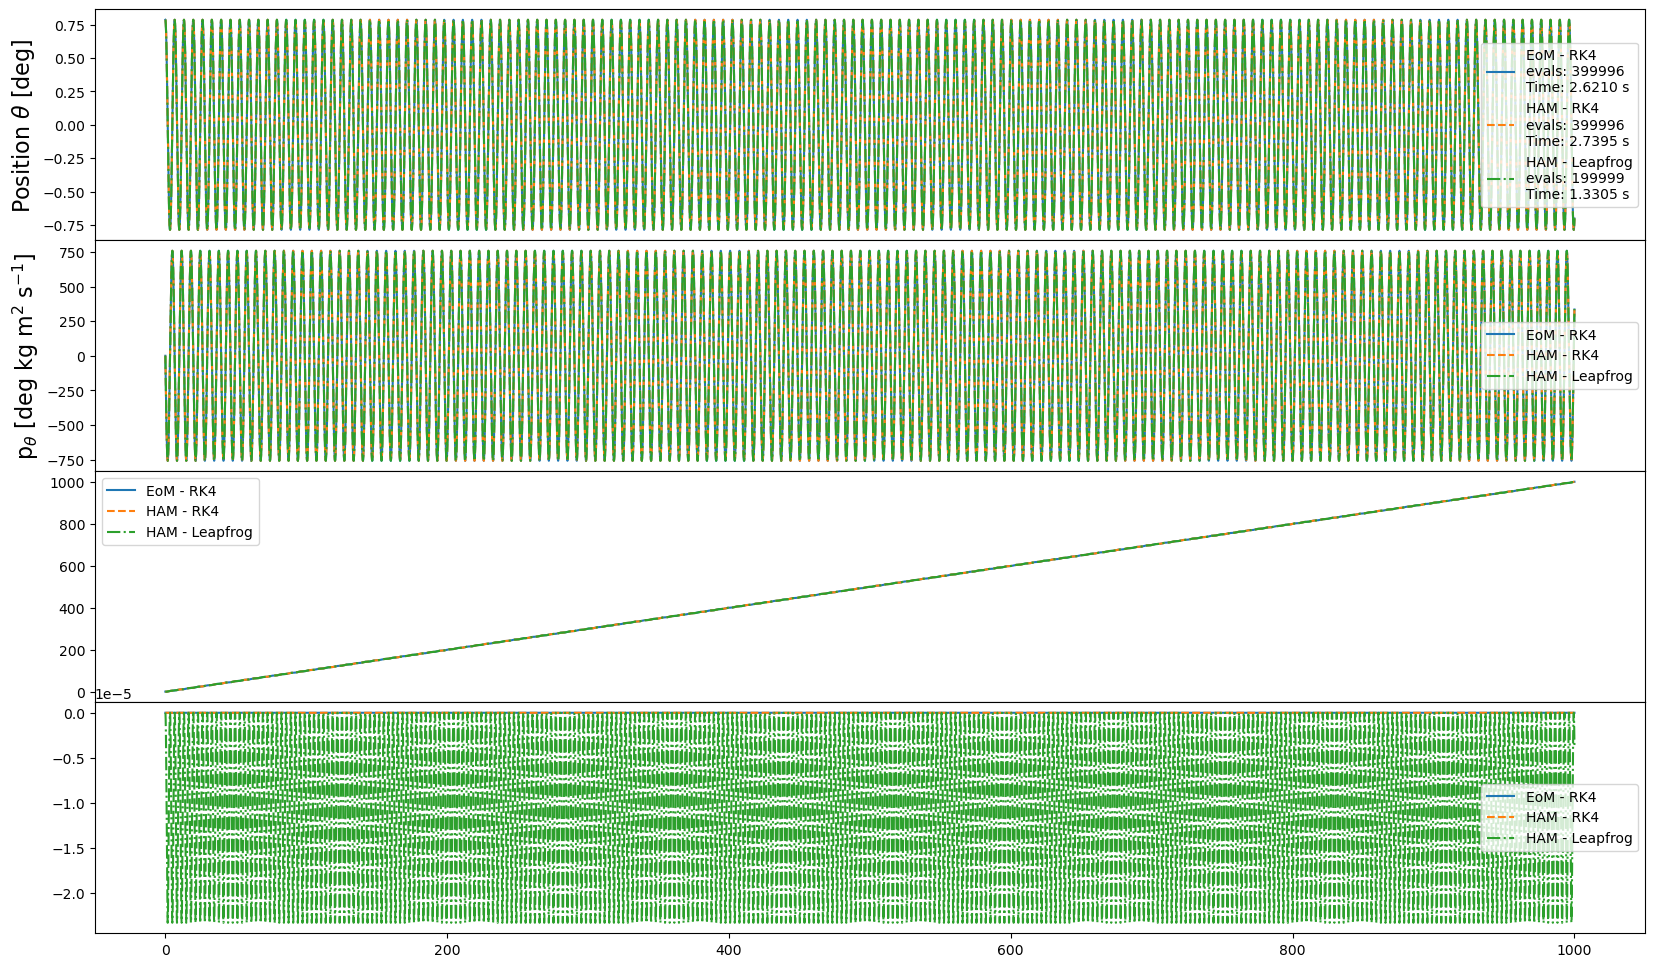

In [68]:
def plot_overview(cases, benchmark, 
                 position = True,
                 momenta = True,
                 benchmark_difference = True, 
                 hamiltonian = True, 
                 styles = ['-' for i in range(10000)]): 

    # Prepare plot
    plots = int(position+momenta+benchmark_difference+hamiltonian)
    fig, axes = plt.subplots(plots, 1, figsize = (plots*5, 12), sharex = True) 
    fig.subplots_adjust(hspace=0)
    
    # Interpolate benchmark solution
    cs = CubicSpline(benchmark.states_can[:,0], benchmark.states_can[:,0]) 
        
    subplot_iterator = 0
    
    # Iterate over solutions to plot
    for case_iterator, case in enumerate(cases): 
        
        H0 = pendulum_hamiltonian(case.states_can[0,1:], m, l)
        
        if position: 
            axes[subplot_iterator].plot(case.states_can[:,0], 
                                        case.states_can[:,1], 
                                        label = f"{case.name}\nevals: {case.func_evals}\nTime: {case.time:.{4}f} s", 
                                       linestyle = styles[case_iterator])
            axes[subplot_iterator].set_ylabel(r"Position $\theta$ [deg]", fontsize = 16) 
            subplot_iterator += 1 
            
        if momenta:
            axes[subplot_iterator].plot(case.states_can[:,0], 
                                        case.states_can[:,2], 
                                        label = case.name, 
                                       linestyle = styles[case_iterator])
            axes[subplot_iterator].set_ylabel(r"p$_{\theta}$ [deg kg m$^2$ s$^{-1}$]", fontsize = 16) 
            subplot_iterator += 1
            
        if benchmark_difference:
            axes[subplot_iterator].plot(states_leapfrog[:,0], 
                                        np.abs(case.states_can[:,1] - cs(case.states_can[:,0])), 
                                        label = case.name, 
                                       linestyle = styles[case_iterator])
            subplot_iterator += 1
            
        if hamiltonian: 
            axes[subplot_iterator].plot(case.states_can[:,0], 
                                       (pendulum_hamiltonian(case.states_can[:,1:], m, l) - H0)/H0, 
                                        label = case.name, 
                                       linestyle = styles[case_iterator])
            subplot_iterator += 1
        
        subplot_iterator = 0
    
    # style the plots
    for ax in axes: 
        ax.legend()

    return True


plot_overview([case for case in cases if case.integrator in ["Leapfrog", "RK4"]], cases[0], styles = ['-', '--', "-."])